In [ ]:
#pip install tensorflow numpy sklearn

In [ ]:
!pip install datasets
!pip install conllu
!pip install --upgrade datasets

In [ ]:
#!rm -rf ~/.cache/huggingface/datasets
#!rm -rf /root/.cache/huggingface/datasets
#!rm -rf /content/.cache/huggingface/datasets

## Load the data

In [ ]:
import numpy as np
from collections import defaultdict, Counter
from datasets import load_dataset

In [ ]:
dataset = load_dataset("universal_dependencies", "en_ewt")

train_data = dataset["train"]
dev_data = dataset["validation"]
test_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/191k [00:00<?, ?B/s]

universal_dependencies.py:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

In [ ]:
train_data

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 12543
})

## Preprocess data for MLP Input

In [ ]:
window_size = 5
pad_size = window_size // 2

In [ ]:
word2idx = defaultdict(lambda: len(word2idx))
tag2idx = defaultdict(lambda: len(tag2idx))

word2idx["<PAD>"]
word2idx["<UNK>"]

def extract_sequences(dataset):
    sequences = []
    for item in dataset:
        tokens = item['tokens']
        tags = item['upos']
        sequences.append((tokens, tags))
    return sequences

In [ ]:
train_seqs = extract_sequences(train_data)
dev_seqs = extract_sequences(dev_data)
test_seqs = extract_sequences(test_data)

In [ ]:
train_seqs[1]

(['[',
  'This',
  'killing',
  'of',
  'a',
  'respected',
  'cleric',
  'will',
  'be',
  'causing',
  'us',
  'trouble',
  'for',
  'years',
  'to',
  'come',
  '.',
  ']'],
 [1, 8, 0, 2, 8, 6, 0, 17, 17, 16, 11, 0, 2, 0, 7, 16, 1, 1])

In [ ]:
# Indexing words from training set
for tokens, tags in train_seqs:
    for token in tokens:
        word2idx[token.lower()]

## Dataset Statistics

In [ ]:
print(f'Vocabulary size: {len(word2idx)}')

Vocabulary size: 17052


In [ ]:
num_train_sent = len(train_seqs)
num_val_sent = len(dev_seqs)
num_test_sent = len(test_seqs)
print(f'training sequences length: {num_train_sent}')
print(f'development sequences length: {num_val_sent}')
print(f'test sequences length: {num_test_sent}')

training sequences length: 12543
development sequences length: 2002
test sequences length: 2077


In [ ]:
def total_token_count(sequences):
    return sum(len(tokens) for tokens, _ in sequences)

train_token_count = total_token_count(train_seqs)
val_token_count = total_token_count(dev_seqs)
test_token_count = total_token_count(test_seqs)

print(f'training tokens count: {train_token_count}')
print(f'development tokens count: {val_token_count}')
print(f'test tokens count: {test_token_count}')

training tokens count: 207053
development tokens count: 25478
test tokens count: 25429


In [ ]:
def average_sentence_length(sequences):
    return sum(len(tokens) for tokens, _ in sequences) / len(sequences)

avg_train_length = average_sentence_length(train_seqs)
avg_val_length = average_sentence_length(dev_seqs)
avg_test_length = average_sentence_length(test_seqs)

print(f'average training sentence length: {avg_train_length:.2f}')
print(f'average development sentence length: {avg_val_length:.2f}')
print(f'average test sentence length: {avg_test_length:.2f}')

average training sentence length: 16.51
average development sentence length: 12.73
average test sentence length: 12.24


In [ ]:
def get_unique_tags(sequences):
    tag_set = set()
    for _, tags in sequences:
        tag_set.update(tags)
    return tag_set

pos_tags = get_unique_tags(train_seqs)
num_tags = len(pos_tags)
int2tag = train_data.features["upos"].feature.int2str

print(f'unique POS tags: {int2tag(pos_tags)}')
print(f'number of tags: {num_tags}')

unique POS tags: ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', '_', 'ADV', 'INTJ', 'VERB', 'AUX']
number of tags: 18


#### Top 5 most frequent tags

In [ ]:
def get_tag_freqs(sequences):
    counter = Counter()
    for _, tag_ids in sequences:
        counter.update(tag_ids)
    return counter

tag_freqs = get_tag_freqs(train_seqs)
for tag_id, count in tag_freqs.most_common(5):
    print(f"{int2tag(tag_id)}: {count}")

NOUN: 34786
PUNCT: 23676
VERB: 23028
PRON: 18584
ADP: 17625


## Convert to Windowed Input Features

In [ ]:
def create_windows(sequences, word2idx, windowSize):
    pad = ['<PAD>'] * (window_size // 2)
    X, y = [], []
    for tokens, tags in sequences:
        tokens = pad + [t.lower() for t in tokens] + pad
        for i in range(len(tags)):
            window = tokens[i:i + window_size]
            X.append([word2idx.get(w, word2idx["<UNK>"]) for w in window])
            y.append(tags[i])
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = create_windows(train_seqs, word2idx, window_size)
X_dev, y_dev = create_windows(dev_seqs, word2idx, window_size)
X_test, y_test = create_windows(test_seqs, word2idx, window_size)

## Download GloVe (pre-trained embeddings)

In [ ]:
import requests, zipfile, io

url = "https://nlp.stanford.edu/data/glove.6B.zip"
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extract("glove.6B.100d.txt", path=".")

In [ ]:
def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    # Initialize random embeddings
    embeddings = np.random.uniform(-0.05, 0.05, (len(word2idx), embedding_dim)).astype(np.float32)
    embeddings[word2idx["<PAD>"]] = np.zeros(embedding_dim)
    embeddings[word2idx["<UNK>"]] = np.random.uniform(-0.05, 0.05, embedding_dim).astype(np.float32) # Initialize <UNK> randomly


    # Load GloVe into a dict
    glove_dict = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype=np.float32)
            glove_dict[word] = vector

    # Fill in known words
    found = 0
    for word, idx in word2idx.items():
        if word in glove_dict:
            embeddings[idx] = glove_dict[word]
            found += 1

    print(f"Matched {found} / {len(word2idx)} words from your vocab ({found / len(word2idx):.2%})")
    return embeddings


In [ ]:
glove_path = "glove.6B.100d.txt"  # Download from https://nlp.stanford.edu/projects/glove/
embedding_matrix = load_glove_embeddings(glove_path, word2idx, embedding_dim=100)

Matched 15097 / 17052 words from your vocab (88.54%)


In [ ]:
embedding_matrix.shape

(17052, 100)

In [ ]:
word2idx[1]

17052

In [ ]:
if embedding_matrix.shape[0] != len(word2idx):
    diff = len(word2idx) - embedding_matrix.shape[0]
    # If word2idx has more entries, extend embedding matrix with random vectors
    if diff > 0:
        padding = np.random.uniform(-0.05, 0.05, (diff, embedding_matrix.shape[1])).astype(np.float32)
        embedding_matrix = np.concatenate([embedding_matrix, padding], axis=0)
    # If embedding_matrix has more entries, trim it to match word2idx (less likely)
    elif diff < 0:
        embedding_matrix = embedding_matrix[:len(word2idx)]

## MLP

In [ ]:
import torch
import torch.nn as nn
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [ ]:
class PoSMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, windowSize,
                 hidden_layers=None, dropout=0.0, batch_norm=False,
                 layer_norm=False, num_classes=20, embedding_weights=None,
                 freeze_embeddings=True):
        super(PoSMLP, self).__init__()

        # 1. Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_weights is not None:
            self.embedding.weight.data.copy_(torch.tensor(embedding_weights))
            self.embedding.weight.requires_grad = not freeze_embeddings

        input_dim = embedding_dim * window_size  # e.g. 100 x 5 = 500

        # 2. Feedforward layers
        layers = []
        prev_dim = input_dim

        if hidden_layers:
            for hidden_dim in hidden_layers:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.ReLU())
                if batch_norm:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                if layer_norm:
                    layers.append(nn.LayerNorm(hidden_dim))
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))
                prev_dim = hidden_dim

        # 3. Output layer
        layers.append(nn.Linear(prev_dim, num_classes))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, window_size)
        emb = self.embedding(x)                    # (batch_size, window_size, embedding_dim)
        flat = emb.view(emb.size(0), -1)           # (batch_size, window_size * embedding_dim)
        return self.net(flat)                      # logits over POS classes


In [ ]:
model = PoSMLP(
    vocab_size=len(word2idx),
    embedding_dim=100,
    windowSize=window_size,
    hidden_layers=[128, 64],
    dropout=0.5,
    batch_norm=False,
    layer_norm=False,
    num_classes=len(train_data.features["upos"].feature.names),
    embedding_weights=embedding_matrix,
    freeze_embeddings=True )

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, model_name=""):
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_model_path = None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()

    # Save the best model ONCE after training
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    save_path = "/content/drive/MyDrive/best_mlp_model.pth"
    torch.save(best_state_dict, save_path)
    print(f"\n✅ Best model saved ONCE to: {save_path}")


    print(f"\nBest model saved as: {best_model_path}")


    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y_batch.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\nEvaluation:\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    return accuracy, precision, recall, f1


In [ ]:
hyperparams_grid = [
    {"hidden_layers": [128], "dropout": 0.3},
    {"hidden_layers": [128, 64], "dropout": 0.3},
    {"hidden_layers": [256], "dropout": 0.5},
    {"hidden_layers": [256, 128, 64], "dropout": 0.4},
    {"hidden_layers": [128, 64], "batch_norm": True, "dropout": 0.3},
    {"hidden_layers": [128, 64], "layer_norm": True, "dropout": 0.3}
]


In [ ]:
def tune_and_compare_models(hyperparams_grid, word2idx, embedding_matrix, train_loader, val_loader, tag_count):
    best_f1 = 0.0
    best_config = None
    best_model_state = None
    results = []

    for i, params in enumerate(hyperparams_grid):
        print(f"\n=== Trying Model {i+1}: {params} ===")

        model = PoSMLP(
            vocab_size=len(word2idx),
            embedding_dim=100,
            windowSize=5,
            hidden_layers=params["hidden_layers"],
            dropout=params["dropout"],
            batch_norm=params.get("batch_norm", False),
            layer_norm=params.get("layer_norm", False),
            num_classes=tag_count,
            embedding_weights=embedding_matrix,
            freeze_embeddings=True
        )

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, model_name=f"model_{i+1}")

        acc, prec, rec, f1 = evaluate_model(model, val_loader)

        results.append({
            "config": params,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        })

        if f1 > best_f1:
            best_f1 = f1
            best_config = params
            best_model_state = model.state_dict()

    print("\n=== Tuning Complete ===")
    print(f"Best Config: {best_config} with F1 = {best_f1:.4f}")
    return best_config, best_model_state, results


In [ ]:
def create_dataloader(X, y, batch_size=64, shuffle=False):
    tensor_X = torch.tensor(X, dtype=torch.long)
    tensor_y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(tensor_X, tensor_y)

    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
train_loader = create_dataloader(X_train, y_train, batch_size=128, shuffle=True)
dev_loader = create_dataloader(X_dev, y_dev, batch_size=128, shuffle=False)
test_loader = create_dataloader(X_test, y_test, batch_size=128, shuffle=False)


=== Trying Model 1: {'hidden_layers': [128], 'dropout': 0.3} ===
Epoch 1/20 | Train Loss: 0.6497 | Val Loss: 0.4467
Epoch 6/20 | Train Loss: 0.2532 | Val Loss: 0.3223
Epoch 11/20 | Train Loss: 0.2138 | Val Loss: 0.3202
Epoch 16/20 | Train Loss: 0.1958 | Val Loss: 0.3164
Mounted at /content/drive

✅ Best model saved ONCE to: /content/drive/MyDrive/best_mlp_model.pth

Best model saved as: None


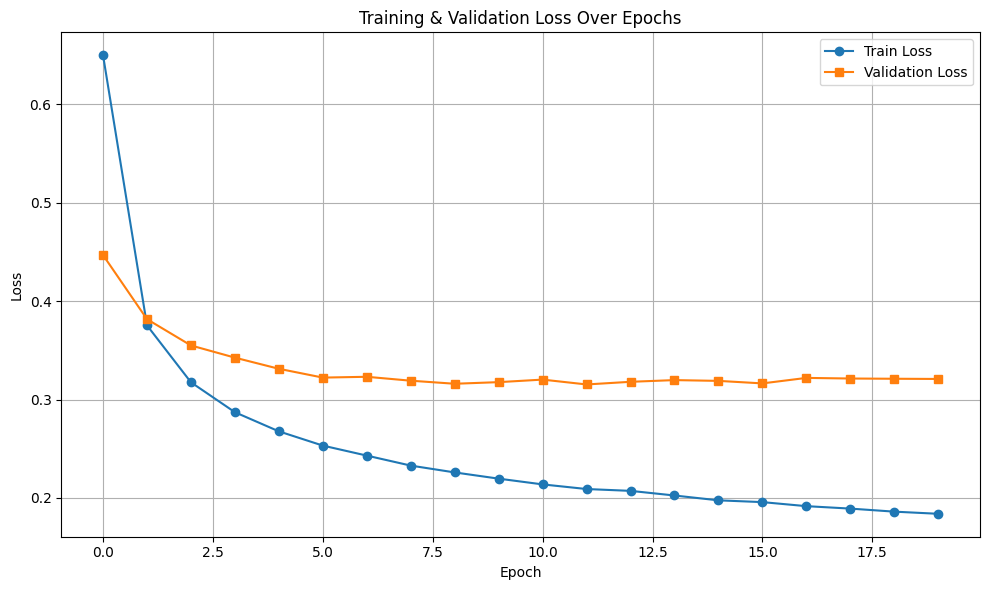


Evaluation:
Accuracy: 0.9047 | Precision: 0.8831 | Recall: 0.8381 | F1: 0.8561

=== Trying Model 2: {'hidden_layers': [128, 64], 'dropout': 0.3} ===
Epoch 1/20 | Train Loss: 0.7453 | Val Loss: 0.4518
Epoch 6/20 | Train Loss: 0.3064 | Val Loss: 0.3327
Epoch 11/20 | Train Loss: 0.2680 | Val Loss: 0.3130
Epoch 16/20 | Train Loss: 0.2492 | Val Loss: 0.3192
Mounted at /content/drive

✅ Best model saved ONCE to: /content/drive/MyDrive/best_mlp_model.pth

Best model saved as: None


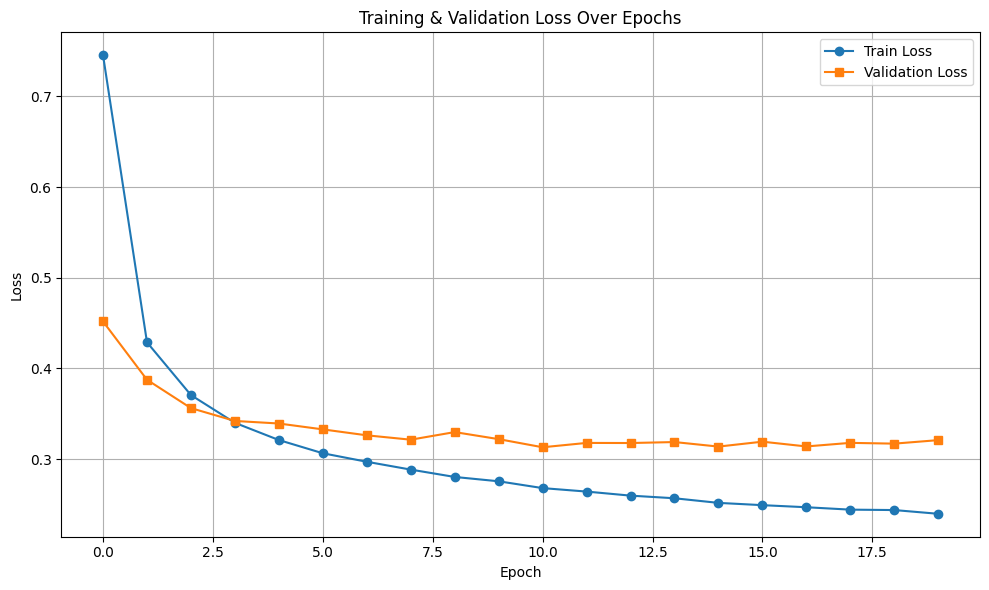


Evaluation:
Accuracy: 0.9020 | Precision: 0.8706 | Recall: 0.8369 | F1: 0.8491

=== Trying Model 3: {'hidden_layers': [256], 'dropout': 0.5} ===
Epoch 1/20 | Train Loss: 0.6296 | Val Loss: 0.4343
Epoch 6/20 | Train Loss: 0.2615 | Val Loss: 0.3237
Epoch 11/20 | Train Loss: 0.2202 | Val Loss: 0.3090
Epoch 16/20 | Train Loss: 0.1980 | Val Loss: 0.3112
Mounted at /content/drive

✅ Best model saved ONCE to: /content/drive/MyDrive/best_mlp_model.pth

Best model saved as: None


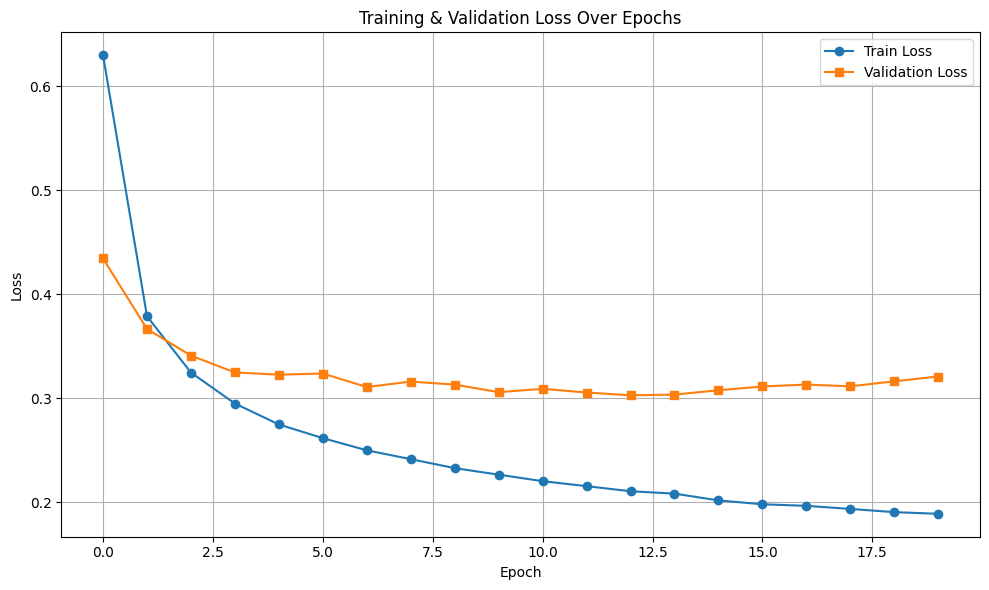


Evaluation:
Accuracy: 0.9066 | Precision: 0.8852 | Recall: 0.8458 | F1: 0.8602

=== Trying Model 4: {'hidden_layers': [256, 128, 64], 'dropout': 0.4} ===
Epoch 1/20 | Train Loss: 0.8012 | Val Loss: 0.4652
Epoch 6/20 | Train Loss: 0.3201 | Val Loss: 0.3300
Epoch 11/20 | Train Loss: 0.2759 | Val Loss: 0.3183
Epoch 16/20 | Train Loss: 0.2524 | Val Loss: 0.3101
Mounted at /content/drive

✅ Best model saved ONCE to: /content/drive/MyDrive/best_mlp_model.pth

Best model saved as: None


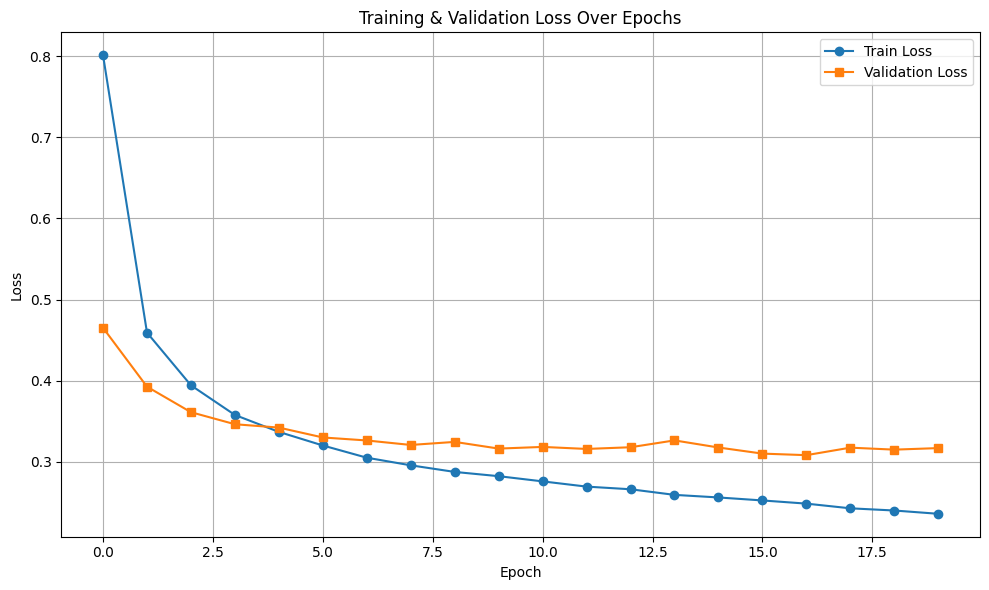


Evaluation:
Accuracy: 0.9050 | Precision: 0.8734 | Recall: 0.8423 | F1: 0.8527

=== Trying Model 5: {'hidden_layers': [128, 64], 'batch_norm': True, 'dropout': 0.3} ===
Epoch 1/20 | Train Loss: 0.6302 | Val Loss: 0.4242
Epoch 6/20 | Train Loss: 0.3037 | Val Loss: 0.3347
Epoch 11/20 | Train Loss: 0.2651 | Val Loss: 0.3150
Epoch 16/20 | Train Loss: 0.2417 | Val Loss: 0.3022
Mounted at /content/drive

✅ Best model saved ONCE to: /content/drive/MyDrive/best_mlp_model.pth

Best model saved as: None


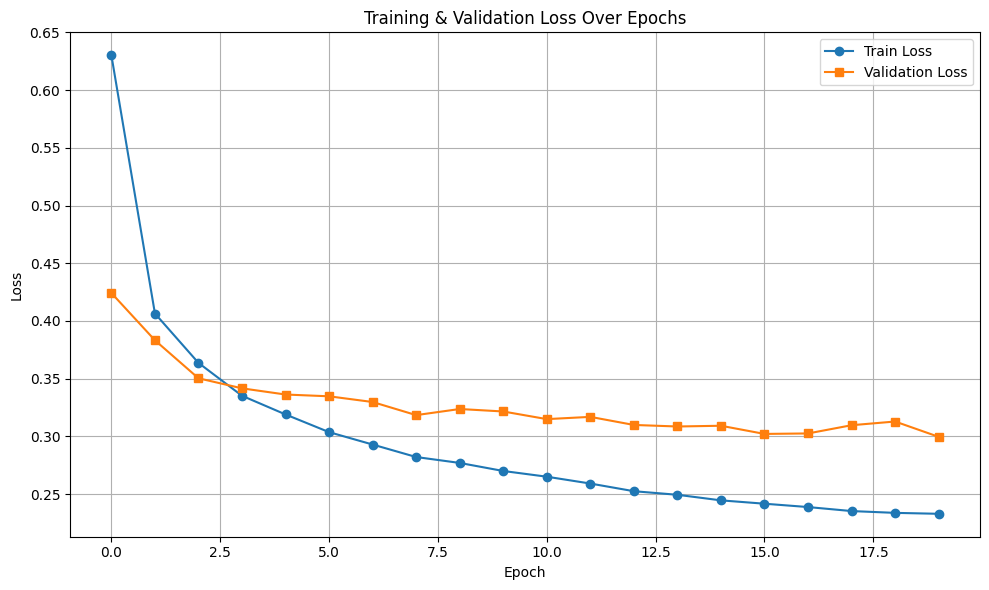


Evaluation:
Accuracy: 0.9080 | Precision: 0.8878 | Recall: 0.8414 | F1: 0.8574

=== Trying Model 6: {'hidden_layers': [128, 64], 'layer_norm': True, 'dropout': 0.3} ===
Epoch 1/20 | Train Loss: 0.6466 | Val Loss: 0.4269
Epoch 6/20 | Train Loss: 0.2911 | Val Loss: 0.3308
Epoch 11/20 | Train Loss: 0.2488 | Val Loss: 0.3162
Epoch 16/20 | Train Loss: 0.2280 | Val Loss: 0.3121
Mounted at /content/drive

✅ Best model saved ONCE to: /content/drive/MyDrive/best_mlp_model.pth

Best model saved as: None


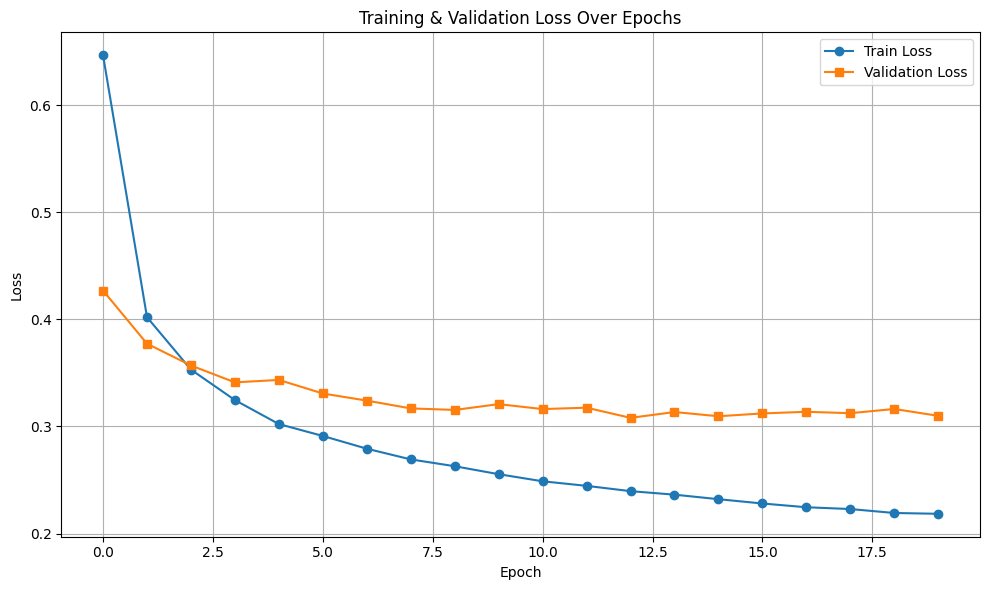


Evaluation:
Accuracy: 0.9059 | Precision: 0.8764 | Recall: 0.8443 | F1: 0.8557

=== Tuning Complete ===
Best Config: {'hidden_layers': [256], 'dropout': 0.5} with F1 = 0.8602


In [ ]:
tag_count = len(train_data.features["upos"].feature.names)

best_config, best_model_state, all_results = tune_and_compare_models(
    hyperparams_grid, word2idx, embedding_matrix,
    train_loader, dev_loader, tag_count )

In [ ]:
# load best model weights
best_model = PoSMLP(
    vocab_size=len(word2idx),
    embedding_dim=100,
    windowSize=5,
    hidden_layers=best_config["hidden_layers"],
    dropout=best_config["dropout"],
    batch_norm=best_config.get("batch_norm", False),
    layer_norm=best_config.get("layer_norm", False),
    num_classes=len(train_data.features["upos"].feature.names),
    embedding_weights=embedding_matrix,
    freeze_embeddings=True)

best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [ ]:
# for evaluation metrics
def evaluate_model_with_auc(model, data_loader, idx2tag):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(y_batch.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            y_probs.extend(probs.cpu().tolist())

    # Basic scores
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[idx2tag[i] for i in range(len(idx2tag))]))

    # AUC
    y_true_bin = label_binarize(y_true, classes=list(range(len(idx2tag))))
    y_probs = np.array(y_probs)

    pr_auc = {}
    auc_sum = 0
    valid_classes = 0

    for i, class_name in enumerate(idx2tag):
      if np.sum(y_true_bin[:, i]) == 0:
            continue  # skip classes not in y_true
      precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
      score = auc(recall_vals, precision_vals)
      pr_auc[class_name] = score
      auc_sum += score
      valid_classes += 1

    macro_auc = auc_sum / valid_classes if valid_classes > 0 else 0
    print("\n📈 Precision-Recall AUC per tag:")
    for tag, score in pr_auc.items():
        print(f"{tag:>6}: {score:.4f}")

    print(f"\n🔹 Macro-averaged PR AUC: {macro_auc:.4f}")


In [ ]:
print("\n--- Train Set ---")
evaluate_model_with_auc(best_model, train_loader, train_data.features["upos"].feature.names)

print("\n--- Dev Set ---")
evaluate_model_with_auc(best_model, dev_loader, train_data.features["upos"].feature.names)

print("\n--- Test Set ---")
evaluate_model_with_auc(best_model, test_loader, train_data.features["upos"].feature.names)



--- Train Set ---

📊 Classification Report:
              precision    recall  f1-score   support

        NOUN       0.96      0.96      0.96     34786
       PUNCT       1.00      1.00      1.00     23676
         ADP       0.96      0.99      0.98     17625
         NUM       0.98      0.99      0.98      3996
         SYM       0.99      0.85      0.92       643
       SCONJ       0.96      0.89      0.92      4502
         ADJ       0.95      0.94      0.95     12459
        PART       0.98      1.00      0.99      5567
         DET       0.99      0.99      0.99     16284
       CCONJ       1.00      1.00      1.00      6703
       PROPN       0.94      0.92      0.93     12924
        PRON       0.99      0.99      0.99     18584
           X       0.83      0.75      0.79       845
           _       0.99      1.00      1.00      2444
         ADV       0.95      0.93      0.94      9903
        INTJ       0.98      0.86      0.92       688
        VERB       0.96      0.97   

## Baseline

In [ ]:
# word_to_tag_counter: {"cat": {"NOUN": 12, "VERB": 1}, ...}
# most_frequent_tag: the most common POS tag overall
def build_baseline_dict_numeric(sequences):
    word_tag_counts = defaultdict(Counter)
    tag_counts = Counter()

    for tokens, tag_ids in sequences:
        for word, tag in zip(tokens, tag_ids):
            word_tag_counts[word.lower()][tag] += 1
            tag_counts[tag] += 1

    most_frequent_tag = tag_counts.most_common(1)[0][0]
    word_to_best_tag = {word: tag_counter.most_common(1)[0][0] for word, tag_counter in word_tag_counts.items()}
    return word_to_best_tag, most_frequent_tag


In [ ]:
def evaluate_baseline_numeric(sequences, word_to_best_tag, most_frequent_tag):
    y_true, y_pred = [], []
    for tokens, tag_ids in sequences:
        for word, true_tag in zip(tokens, tag_ids):
            predicted_tag = word_to_best_tag.get(word.lower(), most_frequent_tag)
            y_true.append(true_tag)
            y_pred.append(predicted_tag)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("\n🔹 Baseline Evaluation:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return accuracy, precision, recall, f1


In [ ]:
# Baseline
word_to_best_tag, most_frequent_tag = build_baseline_dict_numeric(train_seqs)

dev = evaluate_baseline_numeric(dev_seqs, word_to_best_tag, most_frequent_tag)
test = evaluate_baseline_numeric(test_seqs, word_to_best_tag, most_frequent_tag)


🔹 Baseline Evaluation:
Accuracy:  0.8520
Precision: 0.8618
Recall:    0.7620
F1 Score:  0.7889

🔹 Baseline Evaluation:
Accuracy:  0.8542
Precision: 0.8627
Recall:    0.7741
F1 Score:  0.7950


## Most frequent tag for unknown words

In [ ]:
int2tag = train_data.features["upos"].feature.int2str

In [ ]:
print("Most frequent tag overall (ID):", most_frequent_tag)
print("Most frequent tag overall (label):", int2tag(most_frequent_tag))

Most frequent tag overall (ID): 0
Most frequent tag overall (label): NOUN


In [ ]:
word = "is"
tag_id = word_to_best_tag.get(word.lower(), most_frequent_tag)
print(f'Most frequent tag for "{word}": {int2tag(tag_id)}')

Most frequent tag for "is": AUX


In [ ]:
word = ":"
tag_id = word_to_best_tag.get(word.lower(), most_frequent_tag)
print(f'Most frequent tag for "{word}": {int2tag(tag_id)}')

Most frequent tag for ":": PUNCT


In [ ]:
print("flerb" in word2idx)

False


In [ ]:
word = "flerb"
tag_id = word_to_best_tag.get(word.lower(), most_frequent_tag)
print(f'Most frequent tag for "{word}": {int2tag(tag_id)}')

Most frequent tag for "flerb": NOUN
